In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib import patches
import seaborn as sns
import re
import cellbayesassay as cba
import attila_utils

## Fitted dose-respones data

In [2]:
TI2name = pd.read_excel('../../resources/cell-based-assays/study-TI-to-name.xlsx', index_col=[0, 1])['name']
TI2name_df = pd.read_excel('../../resources/cell-based-assays/study-TI-to-name.xlsx').drop('long name', axis=1)
TI2name_df

,study,TI,name
0,CO25360,TI1,Valproic acid
1,CO25360,TI2,Salbutamol
2,CO25360,TI3,Sildenafil
3,CO25360,TI4,Probenecid
4,CO25360,TI5,Montelukast
5,CO25360,TI6,Felodipine
6,CO25360,TI7,Levetiracetam
7,CO25360,TI8,Nifedipine
8,CO25360,TI9,Acitretin
9,CO25360,TI10,Dasatinib


In [3]:
idatadf1 = cba.idatadf_from_netcdf(subdir='idatadf/', maindir='../../results/2023-09-26-cell-bayes-assays/')

In [4]:
idatas2 = cba.idatas_from_netcdf(subdir='idatas/', maindir='../../results/2024-02-14-cell-bayes/')

In [5]:
idatas3 = cba.idatas_from_netcdf(subdir='idatas/', maindir='../../results/2024-04-21-cell-bayes/')

In [6]:
idatas1 = pd.DataFrame(idatadf1.to_numpy(), index=idatadf1.index, columns=pd.MultiIndex.from_product([['CO25360'], idatadf1.columns])).stack(level=[0, 1])
idatas1 = idatas1.reorder_levels([2, 0, 1, 3])
idatas1 = pd.Series(idatas1.to_numpy(), index=idatas1.index.set_names(['study', 'experiment', 'assay', 'TI']))
idatas = pd.concat([idatas1, idatas2, idatas3])
idatas = idatas.loc[~ idatas.index.duplicated(keep='first')]
idatas

study    experiment                                   assay    TI  
CO25360  Aβ clearance (BV2 cells)                     Aβ42 Ly  TI21    (posterior, log_likelihood, sample_stats, obse...
                                                               TI22    (posterior, log_likelihood, sample_stats, obse...
                                                               TI26    (posterior, log_likelihood, sample_stats, obse...
                                                      Aβ42 SN  TI21    (posterior, log_likelihood, sample_stats, obse...
                                                               TI22    (posterior, log_likelihood, sample_stats, obse...
                                                                                             ...                        
CO28153  Trophic factor withdrawal (primary neurons)  MTT      TI18    (posterior, log_likelihood, sample_stats, obse...
                                                               TI19    (posterior, lo

<Axes: xlabel='study-TI', ylabel='experiment-assay'>

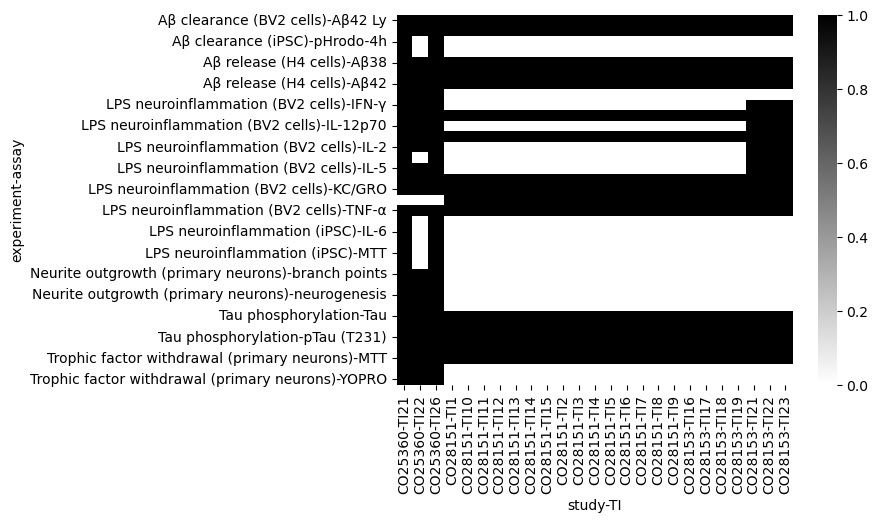

In [7]:
received = idatas.unstack(level=[0, 3]).map(lambda x: not pd.isna(x))
received
fig, ax = plt.subplots()
sns.heatmap(received, ax=ax, cmap='binary')

## Posteriors and Bayes factors

In [8]:
fpathl = [
    '../../results/2023-09-26-cell-bayes-assays/H102_posteriors.csv',
    #'../../results/2024-02-14-cell-bayes/H102_posteriors.csv',
    #'../../results/2024-01-21-cell-bayes-assays-dim/H102_posteriors.csv'
]
l = [pd.read_csv(fpath, index_col=[0, 1], header=[0, 1]) for fpath in fpathl]
H102_posteriors1 = pd.concat([l[0]], axis=1)
#H102_posteriors1 = pd.concat([l[0], l[1].drop('Arundine', level=0, axis=1)], axis=1)
H102_posteriors1 = H102_posteriors1.stack(level=0)
H102_posteriors1['name'] = H102_posteriors1.index.get_level_values(2)
name2TI = {
    'TUDCA': ('CO25360', 'TI21'),
    'Cysteamine': ('CO25360', 'TI22'),
    'Arundine': ('CO25360', 'TI26'),
    'C-DIM5': ('CO28151', 'TI11'),
    'C-DIM12': ('CO28151', 'TI12'),
}
l = [H102_posteriors1.name.apply(lambda x: name2TI[x][i]).to_frame(c) for i, c in zip(range(2), ['study', 'TI'])]
ixdf = pd.concat([l[0], H102_posteriors1.index.to_frame().iloc[:, :-1].rename({0: 'experiment', 1:'assay'}, axis=1), l[1]], axis=1)
H102_posteriors1 = pd.DataFrame(H102_posteriors1.to_numpy(), index=pd.MultiIndex.from_frame(ixdf), columns=H102_posteriors1.columns.to_list())
H102_posteriors1

H1  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26    0.879   
                                                            TI22      0.0   
                                                            TI21  0.99275   
                                                    Aβ42 SN TI26    0.373   
                                                            TI22    0.002   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22  0.00075   
                                                            TI21  0.00025   
                                                    YOPRO   TI26   0.0005   
                                                            TI22      0.0   
                                                            TI21  0.00875   

                                                                       H0  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26     0.12   
                                                            TI22      0.0   
                                                            TI21  0.00725   
                                                    Aβ42 SN TI26   0.6255   
                                                            TI22  0.18175   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22  0.98275   
                                                            TI21  0.93475   
                                                    YOPRO   TI26    0.977   
                                                            TI22  0.95175   
                                                            TI21  0.97275   

                                                                       H2  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26    0.001   
                                                            TI22      1.0   
                                                            TI21      0.0   
                                                    Aβ42 SN TI26   0.0015   
                                                            TI22  0.81625   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22   0.0165   
                                                            TI21    0.065   
                                                    YOPRO   TI26   0.0225   
                                                            TI22  0.04825   
                                                            TI21   0.0185   

                                                                        name  
study   experiment                                  assay   TI                
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26    Arundine  
                                                            TI22  Cysteamine  
                                                            TI21       TUDCA  
                                                    Aβ42 SN TI26    Arundine  
                                                            TI22  Cysteamine  
...                                                                      ...  
        Trophic factor withdrawal (primary neurons) PI      TI22  Cysteamine  
                                                            TI21       TUDCA  
                                                    YOPRO   TI26    Arundine  
                                                            TI22  Cysteamine  
                                                            TI21       TUDCA  

[91 rows x 4 columns]

In [9]:
H102_posteriors2 = pd.read_csv('../../results/2024-02-14-cell-bayes/H102_posteriors.csv', index_col=list(range(4)))
H102_posteriors3 = pd.read_csv('../../results/2024-04-21-cell-bayes/H102_posteriors.csv', index_col=list(range(4)))
H102_posteriors = pd.concat([H102_posteriors1, H102_posteriors2, H102_posteriors3], axis=0)
H102_posteriors = H102_posteriors.loc[~ H102_posteriors.index.duplicated(keep='first')]
H102_posteriors

H1  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26    0.879   
                                                            TI22      0.0   
                                                            TI21  0.99275   
                                                    Aβ42 SN TI26    0.373   
                                                            TI22    0.002   
...                                                                   ...   
CO28153 Trophic factor withdrawal (primary neurons) MTT     TI18  0.00025   
                                                            TI19    0.033   
                                                            TI21  0.02625   
                                                            TI22    0.006   
                                                            TI23      0.0   

                                                                       H0  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26     0.12   
                                                            TI22      0.0   
                                                            TI21  0.00725   
                                                    Aβ42 SN TI26   0.6255   
                                                            TI22  0.18175   
...                                                                   ...   
CO28153 Trophic factor withdrawal (primary neurons) MTT     TI18   0.9985   
                                                            TI19    0.947   
                                                            TI21  0.96325   
                                                            TI22  0.94925   
                                                            TI23  0.84425   

                                                                       H2  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26    0.001   
                                                            TI22      1.0   
                                                            TI21      0.0   
                                                    Aβ42 SN TI26   0.0015   
                                                            TI22  0.81625   
...                                                                   ...   
CO28153 Trophic factor withdrawal (primary neurons) MTT     TI18  0.00125   
                                                            TI19     0.02   
                                                            TI21   0.0105   
                                                            TI22  0.04475   
                                                            TI23  0.15575   

                                                                                                      name  
study   experiment                                  assay   TI                                              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26                                  Arundine  
                                                            TI22                                Cysteamine  
                                                            TI21                                     TUDCA  
                                                    Aβ42 SN TI26                                  Arundine  
                                                            TI22                                Cysteamine  
...                                                                                                    ...  
CO28153 Trophic factor withdrawal (primary neurons) MTT     TI18  (R)Hydroxychloroquine racemic, free base  
                                                            TI19  (R)Hydroxychloroqu

In [10]:
BF10 = cba.BF10_from_H102_posteriors_long(cba.pseudocount_to_H102_posteriors(H102_posteriors))
BF10 = pd. concat([BF10, idatas.apply(lambda x: not pd.isna(x)).to_frame('received')], axis=1)
vmin = BF10['2 log BF'].min()
vmax = BF10['2 log BF'].max()
BF10['2 log BF'] = BF10.apply(lambda r: -1000 if (r.loc['received'] and pd.isna(r.loc['2 log BF'])) else r.loc['2 log BF'], axis=1)
ixdf = BF10.index.to_frame()
ixdf['name'] = ixdf.apply(lambda r: TI2name.loc[(r.loc['study'], r.loc['TI'])], axis=1)
BF10 = pd.DataFrame(BF10.to_numpy(), index=pd.MultiIndex.from_frame(ixdf), columns=BF10.columns)
BF10

Study  \
study   experiment                                  assay        TI   name                    
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly      TI26 Arundine      CO25360   
                                                                 TI22 Cysteamine    CO25360   
                                                                 TI21 TUDCA         CO25360   
                                                    Aβ42 SN      TI26 Arundine      CO25360   
                                                                 TI22 Cysteamine    CO25360   
...                                                                                     ...   
CO28153 Trophic factor withdrawal (primary neurons) MTT          TI22 Belumosudil   CO28153   
                                                                 TI23 Fasudil HCl   CO28153   
CO25360 LPS neuroinflammation (BV2 cells)           IFN-γ        TI26 Arundine          NaN   
        Neurite outgrowth (primary neurons)         neurogenesis TI22 Cysteamine        NaN   
        Tau phosphorylation                         pT/T ratio   TI26 Arundine          NaN   

                                                                                                                     Experiment  \
study   experiment                                  assay        TI   name                                                        
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly      TI26 Arundine                         Aβ clearance (BV2 cells)   
                                                                 TI22 Cysteamine                       Aβ clearance (BV2 cells)   
                                                                 TI21 TUDCA                            Aβ clearance (BV2 cells)   
                                                    Aβ42 SN      TI26 Arundine                         Aβ clearance (BV2 cells)   
                                                                 TI22 Cysteamine                       Aβ clearance (BV2 cells)   
...                                                                                                                         ...   
CO28153 Trophic factor withdrawal (primary neurons) MTT          TI22 Belumosudil   Trophic factor withdrawal (primary neurons)   
                                                                 TI23 Fasudil HCl   Trophic factor withdrawal (primary neurons)   
CO25360 LPS neuroinflammation (BV2 cells)           IFN-γ        TI26 Arundine                                              NaN   
        Neurite outgrowth (primary neurons)         neurogenesis TI22 Cysteamine                                            NaN   
        Tau phosphorylation                         pT/T ratio   TI26 Arundine                                              NaN   

                                                                                      Assay  \
study   experiment                                  assay        TI   name                    
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly      TI26 Arundine      Aβ42 Ly   
                                                                 TI22 Cysteamine    Aβ42 Ly   
                                                                 TI21 TUDCA         Aβ42 Ly   
                                                    Aβ42 SN      TI26 Arundine      Aβ42 SN   
                                                                 TI22 Cysteamine    Aβ42 SN   
...                                                                                     ...   
CO28153 Trophic factor withdrawal (primary neurons) MTT          TI22 Belumosudil       MTT   
                                                                 TI23 Fasudil HCl       MTT   
CO25360 LPS neuroinflammation (BV2 cells)           IFN-γ        TI26 Arundine          NaN   
        Neurite outgrowth (primary neurons)         neurogenesis TI22 Cysteamine        NaN   
      

In [11]:
BF10_wide = BF10['2 log BF'].unstack(level=[0, 3, 4]).astype('float64')
BF10_wide

study                                                            CO25360  \
TI                                                                  TI26   
name                                                            Arundine   
experiment                                  assay                          
Aβ clearance (BV2 cells)                    Aβ42 Ly             3.982586   
                                            Aβ42 SN            -1.033946   
Aβ clearance (iPSC)                         pHrodo-4h          -6.356108   
                                            supernatant       -10.328013   
Aβ release (H4 cells)                       Aβ38               -5.258904   
                                            Aβ40               -5.181072   
                                            Aβ42               -5.031830   
Aβ toxicity (primary neurons)               MTT               -16.554316   
LPS neuroinflammation (BV2 cells)           IFN-γ           -1000.000000   
                                            IL-10              -3.854126   
                                            IL-12p70            2.004611   
                                            IL-1β             -10.809854   
                                            IL-2               -6.099223   
                                            IL-4               17.974394   
                                            IL-5                3.263631   
                                            IL-6               -5.251148   
                                            KC/GRO             -1.088637   
                                            MTT                      NaN   
                                            TNF-α              -4.715134   
LPS neuroinflammation (iPSC)                IL-1β              10.487521   
                                            IL-6               13.001578   
                                            IL-8                8.820540   
                                            MTT               -11.909082   
                                            TNF-α               8.143913   
Neurite outgrowth (primary neurons)         branch points     -17.918623   
                                            longest neurite   -13.766413   
                                            neurogenesis      -15.148604   
                                            Σ neurite area    -17.945181   
Tau phosphorylation                         Tau                -1.923628   
                                            pT/T ratio      -1000.000000   
                                            pTau (T231)        -6.605995   
Trophic factor withdrawal (primary neurons) LDH               -17.939084   
                                            MTT               -17.907797   
                                            PI                 -5.847166   
                                            YOPRO             -15.155268   

study                                                                     \
TI                                                                  TI22   
name                                                          Cysteamine   
experiment                                  assay                          
Aβ clearance (BV2 cells)                    Aβ42 Ly             0.000000   
                                            Aβ42 SN            -9.018970   
Aβ clearance (iPSC)                         pHrodo-4h                NaN   
                                            supernatant              NaN   
Aβ release (H4 cells)                       Aβ38               -4.013673   
                                            Aβ40               -2.372734   
                                            Aβ42               -2.975629   
Aβ toxicity (primary neurons)               MTT                -3.331375   
LPS neuroinflammation (BV2 cells)           IFN-γ              -2.772589   
                                            IL-

['named-figure/cell-based-assays-summary.png',
 'named-figure/cell-based-assays-summary.pdf']

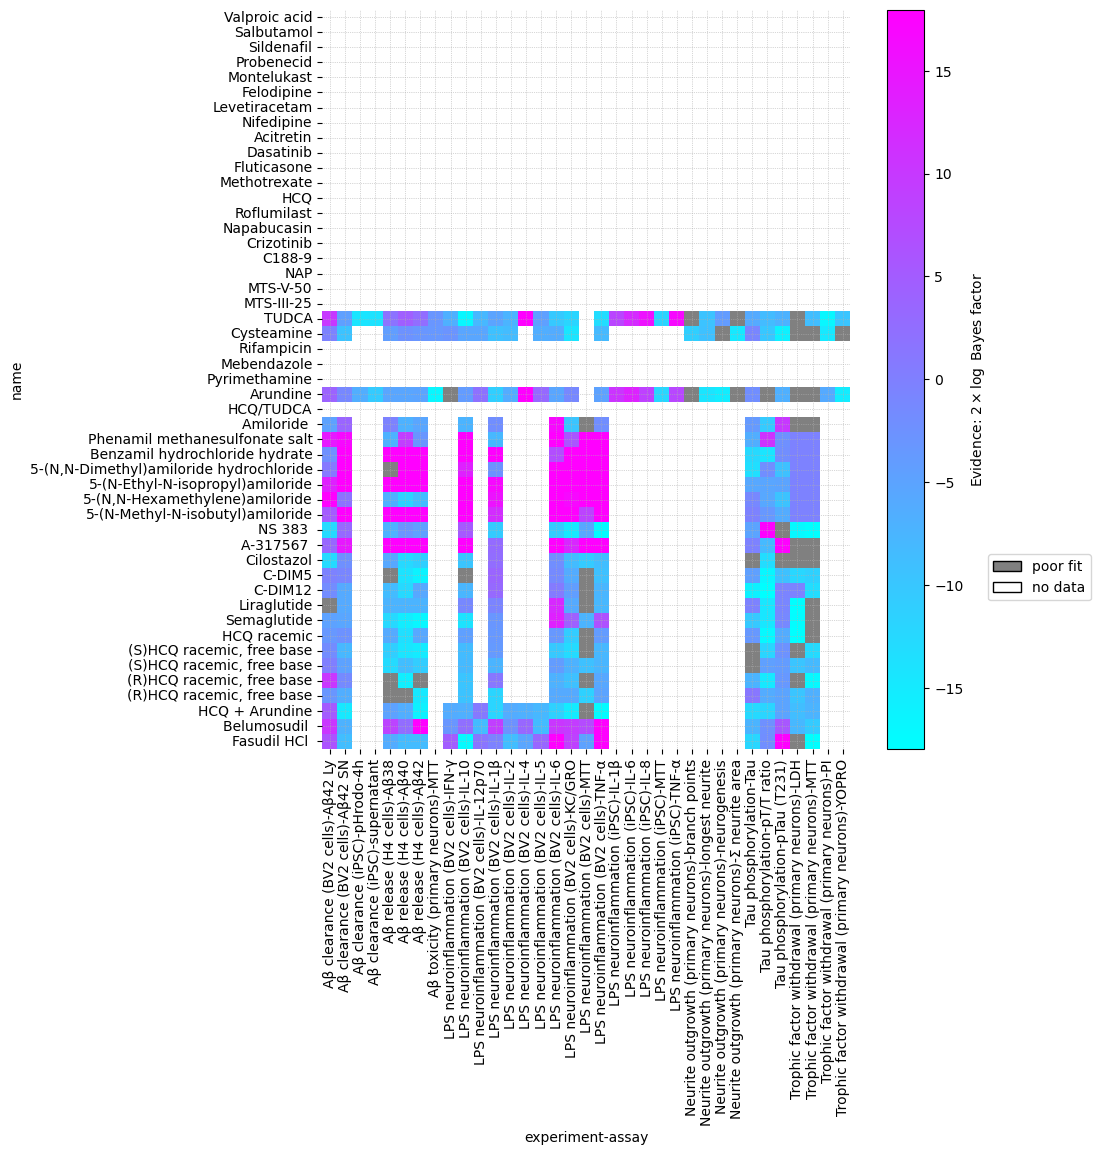

In [12]:
def my_heatmap(data=BF10_wide.reindex(pd.MultiIndex.from_frame(TI2name_df), axis=1).transpose(), vmin=vmin, vmax=vmax):
    cool = matplotlib.colormaps['cool']
    cool_colors = cool(np.linspace(0, 1, 127))
    gray_colors = np.array([[0.5, 0.5, 0.5, 1]])
    my_cmap = ListedColormap(np.concatenate([gray_colors, cool_colors], axis=0))    
    fig, ax = plt.subplots(1, 1, figsize=(9.6, 9.6))
    ax = sns.heatmap(data, ax=ax, cmap=my_cmap, vmin=vmin, vmax=vmax, square=True, cbar=False)
    cbar = fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax, clip=False), cmap='cool'), ax=ax, location='right', label=r'Evidence: $2 \times \log$ Bayes factor')
    ax.grid(axis='both', linewidth=0.5, linestyle='dotted')
    rectangles = [patches.Rectangle((0, 0), 10, 10, facecolor=c, edgecolor='k') for c in ['gray', 'white']]
    fig.legend(rectangles, ['poor fit', 'no data'], loc='center right')
    return((fig, ax))

fig, ax = my_heatmap(BF10_wide.reindex(pd.MultiIndex.from_frame(TI2name_df), axis=1).transpose().droplevel([0, 1], axis=0))
attila_utils.savefig(fig, 'cell-based-assays-summary')

In [13]:
fpath = '../../results/2024-04-09-qps-results-summary/cell-based-assays-Bayes-factors.xlsx'
BF10_wide.reindex(pd.MultiIndex.from_frame(TI2name_df), axis=1).transpose().map(lambda x: 'no data' if pd.isna(x) else x).map(lambda x: 'poor fit' if x == -1000 else x).to_excel(fpath)

## Raw data

In [14]:
fpath = '../../resources/cell-based-assays/data-format-specification_NIA_all-CO28151_CO28153.xlsx'
data = pd.read_excel(fpath, sheet_name='Sheet1')
data

,Study,Experiment,Assay,Batch,Plate,TI,Conc,Activity
0,CO28153,LPS neuroinflammation (BV2 cells),IFN-γ,3,1,LPS,NaN,0.043041
1,CO28153,LPS neuroinflammation (BV2 cells),IFN-γ,3,1,LPS,NaN,0.159173
2,CO28153,LPS neuroinflammation (BV2 cells),IFN-γ,3,1,LPS,NaN,0.029069
3,CO28153,LPS neuroinflammation (BV2 cells),IFN-γ,3,1,LPS,NaN,0.134404
4,CO28153,LPS neuroinflammation (BV2 cells),IFN-γ,3,1,LPS,NaN,0.106824
...,...,...,...,...,...,...,...,...
9253,CO28153,Aβ release (H4 cells),Aβ38,2,3,RI,NaN,735.0628
9254,CO28153,Aβ release (H4 cells),Aβ38,2,3,RI,NaN,641.8745
9255,CO28153,Aβ release (H4 cells),Aβ38,2,3,RI,NaN,660.8184
9256,CO28153,Aβ release (H4 cells),Aβ38,2,3,RI,NaN,696.0789


In [15]:
data1 = data[['Study', 'Experiment', 'Assay', 'TI']]
data1 = data1.loc[data1.TI.apply(lambda x: bool(re.match('TI[0-9]{1,2}.*', x)))]
a, exper_assay_raw = [data1.apply(lambda r: tuple(r.to_list()[i:j]), axis=1).unique() for i, j in [[0, 4], [1, 3]]]
s, s1 = [pd.Series(x) for x in [a, exper_assay_raw]]
available_new, available_new1 = [x.apply(lambda t: pd.Series(t)) for x in [s, s1]]
available_new = available_new.rename({0: 'Study', 1: 'Experiment', 2: 'Assay', 3: 'TI'}, axis=1)
available_new1 = available_new1.rename({0: 'Experiment', 1: 'Assay'}, axis=1)
available_new['Available'] = 2
available_new = available_new.set_index(['Study', 'Experiment', 'Assay', 'TI'])
available_new1

,Experiment,Assay
0,LPS neuroinflammation (BV2 cells),IFN-γ
1,LPS neuroinflammation (BV2 cells),IL-10
2,LPS neuroinflammation (BV2 cells),IL-12p70
3,LPS neuroinflammation (BV2 cells),IL-1β
4,LPS neuroinflammation (BV2 cells),IL-6
5,LPS neuroinflammation (BV2 cells),KC/GRO
6,LPS neuroinflammation (BV2 cells),TNF-α
7,Tau phosphorylation,pT/T ratio
8,Tau phosphorylation,pTau (T231)
9,Tau phosphorylation,Tau


In [16]:
available_new.iloc[267:269]

Available
Study   Experiment            Assay TI             
CO28151 Aβ release (H4 cells) Aβ38  TI12          2
                                    TI13          2

In [17]:
exper_assay_pretty = BF10_wide.index.to_frame()[['experiment', 'assay']].apply(lambda r: tuple(r.to_list()), axis=1).unique()
S_pretty = set(exper_assay_pretty)
S_raw = set(exper_assay_raw)
print('Assays missing from the new dataset:')
print(S_pretty.difference(S_raw))
print('Assays missing from the old dataset:')
S_raw.difference(S_pretty)

Assays missing from the new dataset:
{('LPS neuroinflammation (iPSC)', 'IL-6'), ('Aβ toxicity (primary neurons)', 'MTT'), ('Neurite outgrowth (primary neurons)', 'branch points'), ('Neurite outgrowth (primary neurons)', 'neurogenesis'), ('Aβ clearance (iPSC)', 'supernatant'), ('Neurite outgrowth (primary neurons)', 'longest neurite'), ('LPS neuroinflammation (iPSC)', 'MTT'), ('Trophic factor withdrawal (primary neurons)', 'PI'), ('LPS neuroinflammation (iPSC)', 'IL-1β'), ('LPS neuroinflammation (iPSC)', 'IL-8'), ('Neurite outgrowth (primary neurons)', 'Σ neurite area'), ('Trophic factor withdrawal (primary neurons)', 'YOPRO'), ('Aβ clearance (iPSC)', 'pHrodo-4h'), ('LPS neuroinflammation (iPSC)', 'TNF-α')}
Assays missing from the old dataset:


set()

In [18]:
all_exper_assay = pd.DataFrame(np.array([[t[i] for t in list(S_pretty.union(S_raw))] for i in range(2)]).transpose(), columns=['experiment', 'assay'])
all_exper_assay = all_exper_assay.sort_values(['experiment', 'assay'])
all_exper_assay

,experiment,assay
3,Aβ clearance (BV2 cells),Aβ42 Ly
4,Aβ clearance (BV2 cells),Aβ42 SN
27,Aβ clearance (iPSC),pHrodo-4h
30,Aβ clearance (iPSC),supernatant
11,Aβ release (H4 cells),Aβ38
2,Aβ release (H4 cells),Aβ40
28,Aβ release (H4 cells),Aβ42
22,Aβ toxicity (primary neurons),MTT
19,LPS neuroinflammation (BV2 cells),IFN-γ
8,LPS neuroinflammation (BV2 cells),IL-10


['named-figure/cell-based-assays-summary-all.png',
 'named-figure/cell-based-assays-summary-all.pdf']

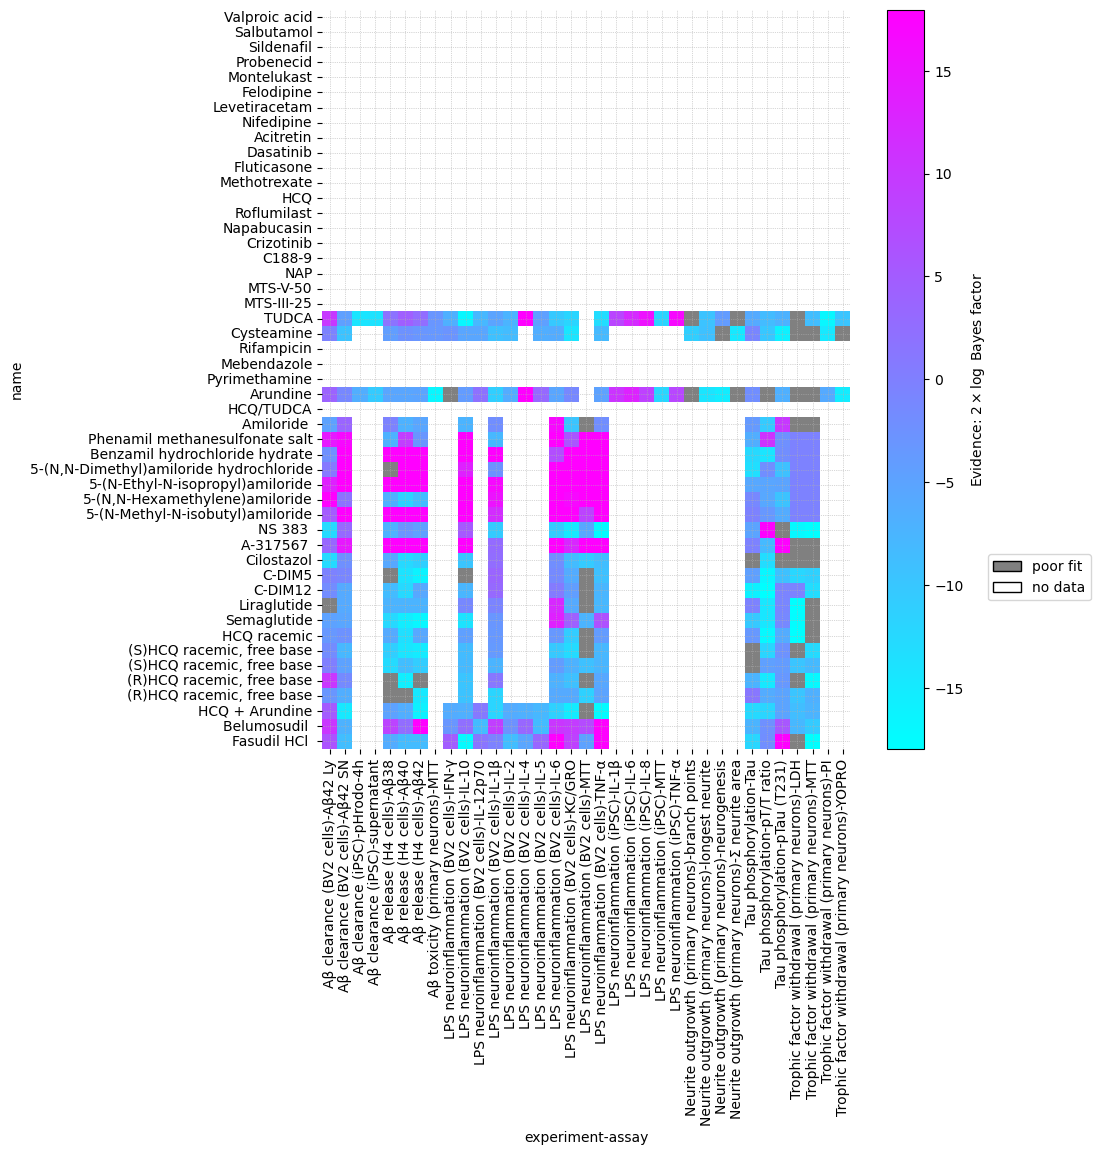

In [19]:
fig, ax = my_heatmap(BF10_wide.reindex(pd.MultiIndex.from_frame(TI2name_df), axis=1).reindex(pd.MultiIndex.from_frame(all_exper_assay), axis=0).transpose().droplevel([0, 1], axis=0))
attila_utils.savefig(fig, 'cell-based-assays-summary-all')

In [20]:
available_old = pd.DataFrame({'Available': 1}, index=idatas.index)
available_old

Available
study   experiment                                  assay   TI             
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI21          1
                                                            TI22          1
                                                            TI26          1
                                                    Aβ42 SN TI21          1
                                                            TI22          1
...                                                                     ...
CO28153 Trophic factor withdrawal (primary neurons) MTT     TI18          1
                                                            TI19          1
                                                            TI21          1
                                                            TI22          1
                                                            TI23          1

[461 rows x 1 columns]

['named-figure/presence-in-old-new-datasets.png',
 'named-figure/presence-in-old-new-datasets.pdf']

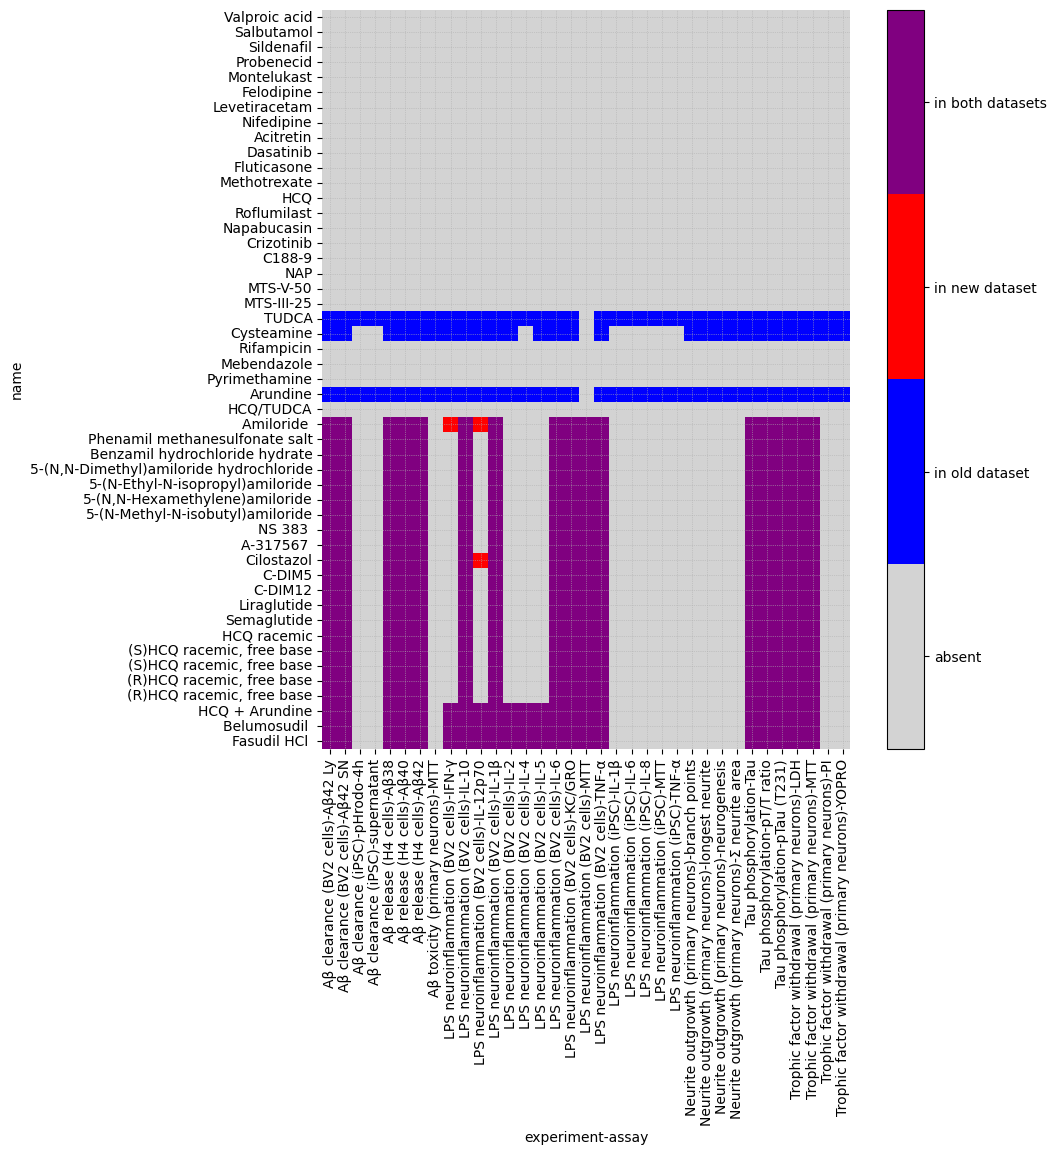

In [21]:
def expand_available_matrix(available, TI2name_df=TI2name_df, all_exper_assay=all_exper_assay):
    df = available['Available'].unstack(level=[1, 2])
    df = df.reindex(pd.MultiIndex.from_frame(TI2name_df.drop('name', axis=1)), axis=0)
    df = df.reindex(pd.MultiIndex.from_frame(all_exper_assay), axis=1)
    df = df.fillna(0)
    return(df)

def my_heatmap_2(data):
    mcmap = matplotlib.colormaps['brg']
    mcmap_colors = mcmap(np.linspace(0, 1, 3))
    gray_colors = np.array([[0.5, 0.5, 0.5, 1]])
    my_cmap = ListedColormap(['lightgray', 'blue', 'red', 'purple'])
    fig, ax = plt.subplots(1, 1, figsize=(9.6, 9.6))
    ax = sns.heatmap(data, ax=ax, cmap=my_cmap, square=True, cbar=False)
    cbar = fig.colorbar(cm.ScalarMappable(cmap=my_cmap), ax=ax, location='right')
    cbar.ax.set_yticks(np.linspace(0.125, 0.875, 4))
    cbar.ax.set_yticklabels(['absent', 'in old dataset', 'in new dataset', 'in both datasets'])
    ax.grid(axis='both', linewidth=0.5, linestyle='dotted')
    return((fig, ax))

available_wide = expand_available_matrix(available_old) + expand_available_matrix(available_new)
fig, ax = my_heatmap_2(pd.DataFrame(available_wide.to_numpy(), index=TI2name_df['name'], columns=available_wide.columns))
attila_utils.savefig(fig, 'presence-in-old-new-datasets')

In [22]:
fpath = '../../results/2024-04-09-qps-results-summary/presence-in-old-new-datasets.xlsx'
df = pd.DataFrame(available_wide.to_numpy(), index=pd.MultiIndex.from_frame(TI2name_df), columns=available_wide.columns)
df = df.map(lambda x: {0: 'absent', 1: 'in old dataset', 2: 'in new dataset', 3: 'in both datasets'}[x])
df.to_excel(fpath)

In [23]:
%connect_info

{
  "shell_port": 60733,
  "iopub_port": 60734,
  "stdin_port": 60735,
  "control_port": 60737,
  "hb_port": 60736,
  "ip": "127.0.0.1",
  "key": "e957f734-66a1d1287cf6a52d24d2271d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-04-09-qps-results-summary/024-04-09-qps-results-summary.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-2c8c38a9-c551-426f-abc2-fd02f5fb270d.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
